In [1]:
import mediapy as media

import math
import numpy as np
import torch
import torch.nn.functional as F

import requests
from io import BytesIO

from PIL import Image
from scipy.ndimage import gaussian_filter
from tqdm.auto import tqdm

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, StableDiffusionImg2ImgPipeline
from diffusers import LMSDiscreteScheduler, DDIMScheduler, PNDMScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [13]:
def latents_to_image(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()[0]
    return image

def latents_out(latents):
    image = latents_to_image(latents)
    image = (image * 255).round().astype("uint8")
    pil_image = Image.fromarray(image)
    return pil_image

def circle_mask(h, w, x, y, r):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - x)**2 + (Y - y)**2)
    mask = torch.from_numpy(dist_from_center <= r)
    mask = mask.type(mask0.dtype).to(device)
    return mask

def stroke(cur_out, pred_out, mask0, ch, V, D, M, move_cost=2.0, finishing_frame=True):
    kernel_schedule = [1, 1, 1, 3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9, 11, 11, 11, 13, 15, 17, 19, 21, 23]
    D_vis = M * D
    C_move = torch.ones_like(mask0)
    mask = torch.zeros_like(mask0)
    for k_size in kernel_schedule:
        w_side = int((k_size-1)/2)
        C = D_vis * C_move
        E = torch.nn.AvgPool2d(k_size, stride=1, divisor_override=1)(C)
        (b0,c0,h0,w0) = E.shape
        r = E[0,ch,:,:].view(1, -1).argsort(1, descending=True)
        indices = torch.cat((((r % (h0*w0)) // w0).view(-1, 1), ((r % (h0*w0)) % w0).view(-1, 1)), dim=1).view(-1, 2)
        p = indices[0] + w_side
        cm = (circle_mask(h, w, p[1].item(), p[0].item(), w_side + 1) + mask[0,ch,:,:]).clamp(0, 1) * mask0[0,ch,:,:]
        mask[0,ch,:,:] = cm
        D_vis[0,ch,:,:] = D_vis[0,ch,:,:] - D_vis[0,ch,:,:] * cm
        G = np.zeros((h,w))
        G[p[0], p[1]] = 1.0
        G = gaussian_filter(G, sigma=max(h,w)/(move_cost+1e-3), truncate=2, mode='constant')
        G = torch.from_numpy(G).float().to(device)
        C_move[0,ch,:,:] = G / G.max()
        V.append(latents_to_image(cur_out * (1-mask) + pred_out * mask))

    if finishing_frame:
        D[0,ch,:,:] = 0
        cur_out = cur_out * (1-M) + pred_out * M
        V.extend([latents_to_image(cur_out)]*1)
    else:
        cur_out = cur_out * (1-mask) + pred_out * mask
    return cur_out

In [7]:
text = "a photograph of an astronaut riding a horse"
seed = 32

prompt = [text]

height = 512
width = 512
num_inference_steps = 30
guidance_scale = 7.5
batch_size = 1
h = height // 8
w = width // 8
n_ch = unet.config.in_channels

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

max_length = text_input.input_ids.shape[-1]

uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  0%|          | 0/30 [00:00<?, ?it/s]

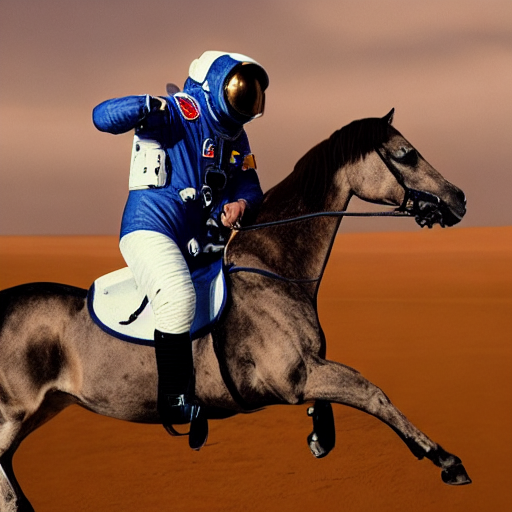

In [10]:
generator = torch.manual_seed(seed)
latents = torch.randn((batch_size, n_ch, h, w), generator=generator)
latents = latents.to(device)

scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    step = scheduler.step(noise_pred, t, latents)
    latents  = step.prev_sample

latents_out(latents)

In [14]:
generator = torch.manual_seed(seed)
latents = torch.randn((batch_size, n_ch, h, w), generator=generator,)
latents = latents.to(device)

scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

d_max = None
p_max = None
r_pad = 1
cur_out = torch.zeros_like(latents)
M = torch.zeros_like(latents)

V = []
cnt = 0
for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    step = scheduler.step(noise_pred, t, latents)
    latents  = step.prev_sample
    pred_out = step.pred_original_sample
    cnt += 1

    p = torch.sum(torch.abs(pred_out - cur_out))
    if p_max is None or p_max < p:
        p_max = p
    if cnt < num_inference_steps:
        rounds = r_pad + int((n_ch-r_pad) * p / p_max)
    else:
        rounds = 4

    for i in range(rounds):
        D = torch.abs(pred_out - cur_out)
        d = torch.sum(D, dim=[2,3])
        ch = torch.argmax(d)
        d = torch.max(d)
        if d_max is None or d_max < d:
            d_max = d

        d_ratio = d / d_max
        #print(f"t = {t}, ch = {ch}, d = {d}, d_ratio = {d_ratio}")

        if d_ratio < 0.5 and t > 1:
            #print("skipped")
            break
        cut = torch.quantile(D[0,ch,:,:], min(d_ratio, 0.8), interpolation='linear')
        mask0 = (D >= cut).type(pred_out.dtype)
        M[0,ch,:,:] = mask0[0,ch,:,:]
        
        cur_out = stroke(cur_out, pred_out, mask0, ch, V, D, M, finishing_frame=True)

V.extend([latents_to_image(cur_out)]*24)
media.show_video(V, fps=12)

  0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.

In [15]:
media.show_video(V, fps=12)

In [16]:
V[0].shape

(512, 512, 3)